In [1]:
# Import Libraries

import pandas as pd
import numpy as np

import zipfile

import math

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import mean_squared_error, r2_score

from pylab import rcParams
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import gc

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Unzip the archive

local_zip = '/content/drive/MyDrive/database.csv.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()

zip_ref.close()

In [3]:
df = pd.read_csv('/content/database.csv')
df

,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
0,01/02/1965,13:44:18,19.2460,145.6160,Earthquake,131.60,NaN,NaN,6.0,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1,01/04/1965,11:29:49,1.8630,127.3520,Earthquake,80.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
2,01/05/1965,18:05:58,-20.5790,-173.9720,Earthquake,20.00,NaN,NaN,6.2,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic
3,01/08/1965,18:49:43,-59.0760,-23.5570,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860856,ISCGEM,ISCGEM,ISCGEM,Automatic
4,01/09/1965,13:32:50,11.9380,126.4270,Earthquake,15.00,NaN,NaN,5.8,MW,...,NaN,NaN,NaN,NaN,NaN,ISCGEM860890,ISCGEM,ISCGEM,ISCGEM,Automatic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23407,12/28/2016,08:22:12,38.3917,-118.8941,Earthquake,12.30,1.2,40.0,5.6,ML,...,18.0,42.47,0.120,NaN,0.1898,NN00570710,NN,NN,NN,Reviewed
23408,12/28/2016,09:13:47,38.3777,-118.8957,Earthquake,8.80,2.0,33.0,5.5,ML,...,18.0,48.58,0.129,NaN,0.2187,NN00570744,NN,NN,NN,Reviewed
23409,12/28/2016,12:38:51,36.9179,140.4262,Earthquake,10.00,1.8,NaN,5.9,MWW,...,NaN,91.00,0.992,4.8,1.5200,US10007NAF,US,US,US,Reviewed
23410,12/29/2016,22:30:19,-9.0283,118.6639,Earthquake,79.00,1.8,NaN,6.3,MWW,...,NaN,26.00,3.553,6.0,1.4300,US10007NL0,US,US,US,Reviewed


In [4]:
df.shape

(23412, 21)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Latitude,23412.0,1.679033,30.113183,-77.080000,-18.65300,-3.5685,26.19075,86.005
Longitude,23412.0,39.639961,125.511959,-179.997000,-76.34975,103.9820,145.02625,179.998
Depth,23412.0,70.767911,122.651898,-1.100000,14.52250,33.0000,54.00000,700.000
Depth Error,4461.0,4.993115,4.875184,0.000000,1.80000,3.5000,6.30000,91.295
Depth Seismic Stations,7097.0,275.364098,162.141631,0.000000,146.00000,255.0000,384.00000,934.000
Magnitude,23412.0,5.882531,0.423066,5.500000,5.60000,5.7000,6.00000,9.100
Magnitude Error,327.0,0.071820,0.051466,0.000000,0.04600,0.0590,0.07550,0.410
Magnitude Seismic Stations,2564.0,48.944618,62.943106,0.000000,10.00000,28.0000,66.00000,821.000
Azimuthal Gap,7299.0,44.163532,32.141486,0.000000,24.10000,36.0000,54.00000,360.000
Horizontal Distance,1604.0,3.992660,5.377262,0.004505,0.96875,2.3195,4.72450,37.874


### **Data Cleaning**

In [7]:
date_len = df.Date.str.len()
date_len.value_counts()

10    23409
24        3
Name: Date, dtype: int64

In [8]:
indices = np.where([date_len == 24])[1]
print('Indices with corrupted data:', indices)
df.loc[indices]

Indices with corrupted data: [ 3378  7512 20650]


,Date,Time,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,...,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
3378,1975-02-23T02:58:41.000Z,1975-02-23T02:58:41.000Z,8.017,124.075,Earthquake,623.0,NaN,NaN,5.6,MB,...,NaN,NaN,NaN,NaN,NaN,USP0000A09,US,US,US,Reviewed
7512,1985-04-28T02:53:41.530Z,1985-04-28T02:53:41.530Z,-32.998,-71.766,Earthquake,33.0,NaN,NaN,5.6,MW,...,NaN,NaN,NaN,NaN,1.30,USP0002E81,US,US,HRV,Reviewed
20650,2011-03-13T02:23:34.520Z,2011-03-13T02:23:34.520Z,36.344,142.344,Earthquake,10.1,13.9,289.0,5.8,MWC,...,NaN,32.3,NaN,NaN,1.06,USP000HWQP,US,US,GCMT,Reviewed


In [9]:
time_len = df.Time.str.len()
time_len.value_counts()

8     23409
24        3
Name: Time, dtype: int64

In [10]:
df.loc[3378, ['Date','Time']] = ['02/23/1975', '02:58:41']
df.loc[7512, ['Date','Time']] = ['04/28/1985', '02:53:41']
df.loc[20650, ['Date','Time']] = ['03/13/2011', '02:23:34']

In [11]:
# Combine the 'Date' and 'Time' columns
df['Datetime'] = df['Date'].astype(str) + ' ' + df['Time'].astype(str)

# Convert the new column to a datetime type
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%m/%d/%Y %H:%M:%S')

columns = df.columns.tolist() # This code positions 'Datetime' in the first index
columns.remove('Datetime')
columns.insert(0, 'Datetime')
df = df.reindex(columns, axis=1)

df['Datetime'].head()

0   1965-01-02 13:44:18
1   1965-01-04 11:29:49
2   1965-01-05 18:05:58
3   1965-01-08 18:49:43
4   1965-01-09 13:32:50
Name: Datetime, dtype: datetime64[ns]

In [12]:
df['Datetime'].min(), df['Datetime'].max()

(Timestamp('1965-01-02 13:44:18'), Timestamp('2016-12-30 20:08:28'))

In [13]:
df['Type'].value_counts()

Earthquake           23232
Nuclear Explosion      175
Explosion                4
Rock Burst               1
Name: Type, dtype: int64

In [14]:
df1 = df.copy

In [15]:
df = df.set_index('Datetime')

df = df.drop(['Date','Time'], axis=1)
df.head(3)

,Latitude,Longitude,Type,Depth,Depth Error,Depth Seismic Stations,Magnitude,Magnitude Type,Magnitude Error,Magnitude Seismic Stations,Azimuthal Gap,Horizontal Distance,Horizontal Error,Root Mean Square,ID,Source,Location Source,Magnitude Source,Status
Datetime,,,,,,,,,,,,,,,,,,,
1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,NaN,NaN,6.0,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860706,ISCGEM,ISCGEM,ISCGEM,Automatic
1965-01-04 11:29:49,1.863,127.352,Earthquake,80.0,NaN,NaN,5.8,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860737,ISCGEM,ISCGEM,ISCGEM,Automatic
1965-01-05 18:05:58,-20.579,-173.972,Earthquake,20.0,NaN,NaN,6.2,MW,NaN,NaN,NaN,NaN,NaN,NaN,ISCGEM860762,ISCGEM,ISCGEM,ISCGEM,Automatic


In [16]:
# Find the columns with null values and their percentage

null_cols = df.columns[df.isnull().any()].tolist()
null_percentages = [np.round(100 * df[col].isnull().mean(), 2) for col in null_cols]

# Print the results
for col, percentage in zip(null_cols, null_percentages):
    print(f"{col}: {percentage}%")

Depth Error: 80.95%
Depth Seismic Stations: 69.69%
Magnitude Type: 0.01%
Magnitude Error: 98.6%
Magnitude Seismic Stations: 89.05%
Azimuthal Gap: 68.82%
Horizontal Distance: 93.15%
Horizontal Error: 95.06%
Root Mean Square: 25.88%


All variables except Magnitude Type that have null values need to be dropped because filling them would make our analysis unreliable.

In [17]:
# Drop columns

cols_to_drop = [col for col in null_cols if col != 'Magnitude Type'] +['ID','Source','Location Source','Magnitude Source','Status'] # ID, sources and status do not add much information for analysis
df = df.drop(cols_to_drop, axis=1)
df.head(2)

,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type
Datetime,,,,,,
1965-01-02 13:44:18,19.246,145.616,Earthquake,131.6,6.0,MW
1965-01-04 11:29:49,1.863,127.352,Earthquake,80.0,5.8,MW


In [18]:
mode = df['Magnitude Type'].mode()[0]

# Fill missing values in the column with the mode
df['Magnitude Type'] = df['Magnitude Type'].fillna(mode)

In [19]:
# Dropping duplicates

df = df[~df.index.duplicated(keep=False)]

In [20]:
gc.collect()

22

### **Exploratory Analysis**

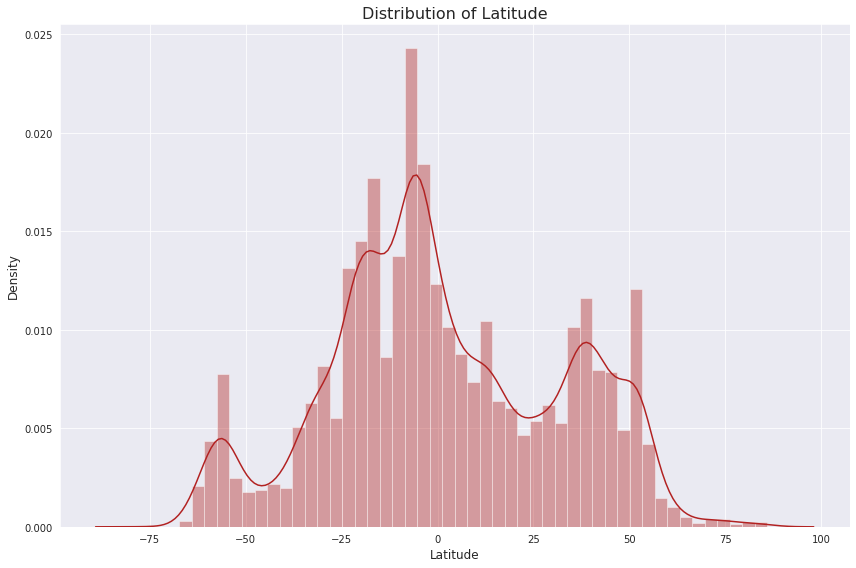

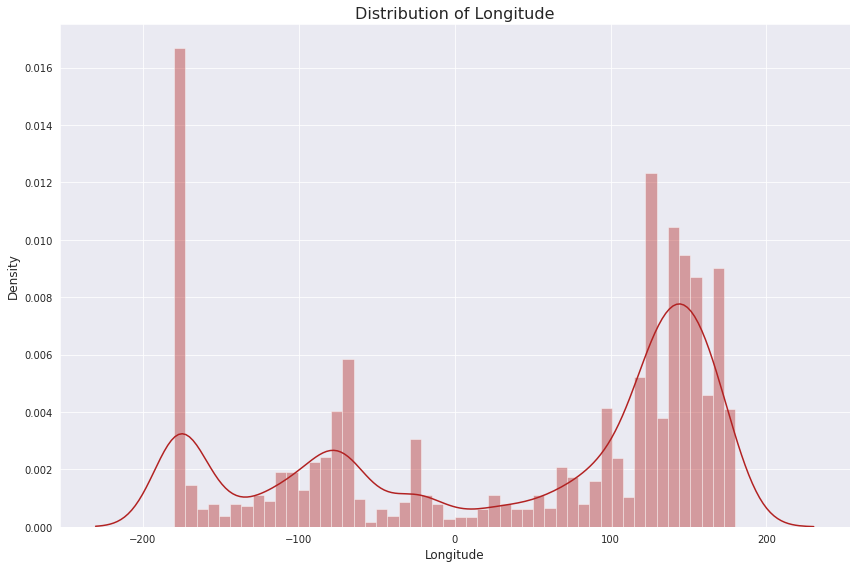

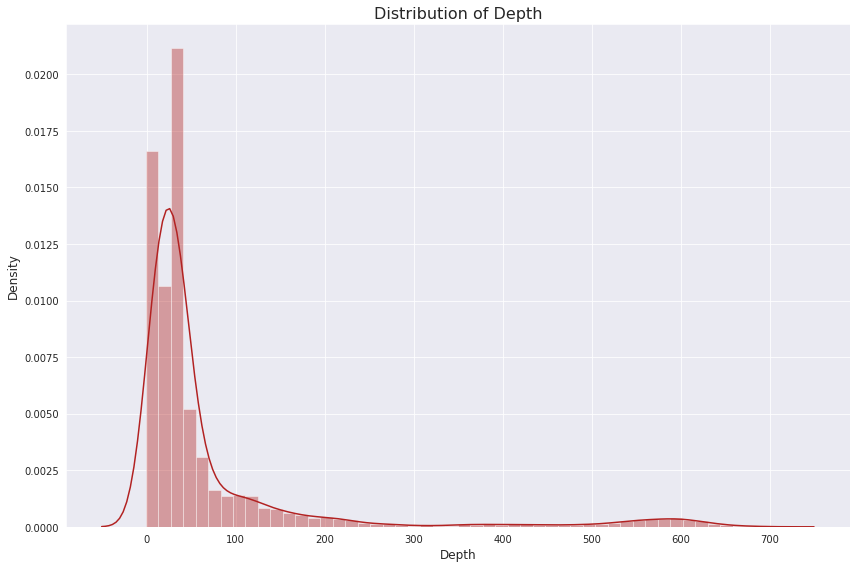

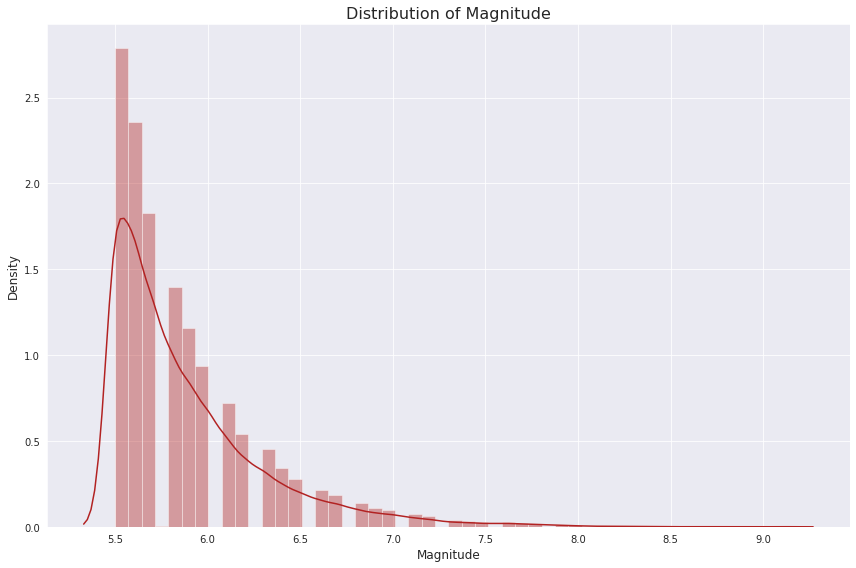

In [21]:
# Plot the distribution of numerical variables

sns.set_style("darkgrid")

for column in df.select_dtypes(include=[np.number]).columns:
    plt.figure(figsize=(12, 8))
    sns.distplot(df[column], bins=50, color='firebrick')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.title(f'Distribution of {column}', fontsize=16)
    plt.tight_layout()
    plt.show()


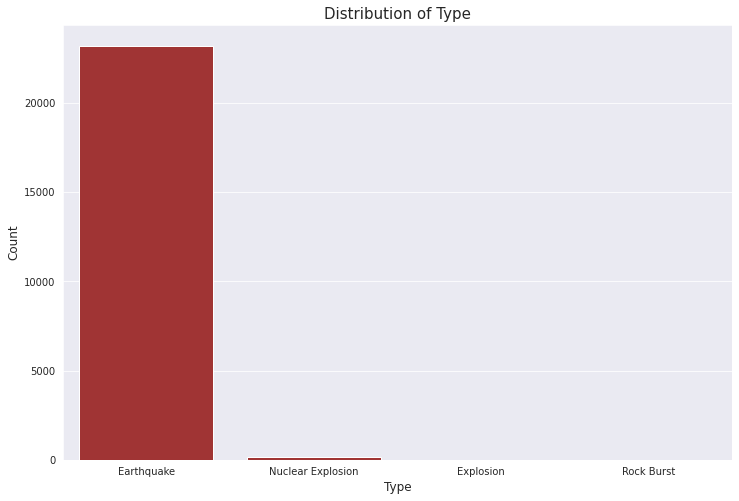

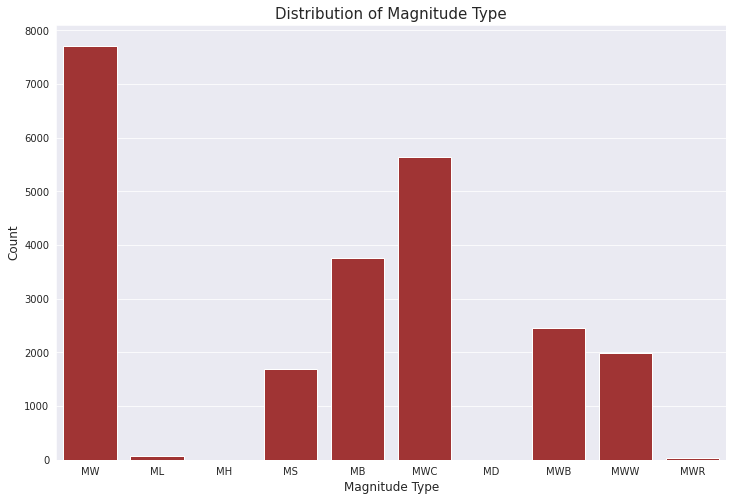

In [22]:
# Plot the distribution of categorical variables

for column in df.select_dtypes(include=['object']).columns:
    plt.figure(figsize=(12, 8))
    sns.countplot(x=column, data=df, color='firebrick')
    plt.xlabel(column, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title(f'Distribution of {column}', fontsize=15)
    plt.show()


**Findings:**

1. Most of the events have taken place between 10 to 5 degrees south of the equator and 115-175 degrees east of the prime meridian. The least number of earthquakes are along the prime meridian give and take 5 degrees and 75-80 degrees north and south of the equator. This means a lot of earhquakes occur along the prime meridian but away from the equator.
2. The distribution of magnitude and depth is heavily skewed to the right with most events in the range of 5.5-6 magnitude and 0-40 in depth.
3. There are negative values in depth which indicates that earthquakes occurred above the Earth's surface. This can occur in areas where the Earth's surface is unstable, such as those near active volcanic regions, where magma and ash can cause the ground to shake and produce earthquakes.
4. The type of event with the most records in this dataset is earthquakes. We will drop rows with other events since they are only 180 and the goal is to predict earthquakes. 
5. The magnitude type that has the highest frequency is MW followed by MWC

### **Pre-Processing**

In [23]:
# Check the skewness of 'Magnitude' and 'Depth'

print('Skewness of Magnitude:', df['Magnitude'].skew())
print('Skewness of Depth:', df['Depth'].skew())

Skewness of Magnitude: 1.8500472047368848
Skewness of Depth: 3.287643376513829


Both variables are highly skewed hence we will perform log transformation

In [24]:
df['Magnitude'] = np.log(df['Magnitude'])
df['Depth'] = np.log(df['Depth'] + 1)
df.head(2)

,Latitude,Longitude,Type,Depth,Magnitude,Magnitude Type
Datetime,,,,,,
1965-01-02 13:44:18,19.246,145.616,Earthquake,4.887337,1.791759,MW
1965-01-04 11:29:49,1.863,127.352,Earthquake,4.394449,1.757858,MW


In [25]:
# Filter the data to only include events with type == "Earthquake"
df = df[df['Type'] == "Earthquake"]
df = df.drop('Type', axis=1) # Dropping the type column since it has earthquakes only

# Define the regions based on latitude and longitude ranges
regions = {
    'North America': [(24, 50), (-125, -60)],
    'South America': [(0, 25), (-90, -30)],
    'Europe': [(35, 70), (-15, 40)],
    'Africa': [(0, 40), (-20, 60)],
    'Asia': [(0, 60), (60, 150)],
    'Oceania': [(-50, 0), (100, 180)],
}

# Loop through the DataFrame and determine the region for the earthquakes
for i, row in df.iterrows():
    lat = row['Latitude']
    lon = row['Longitude']
    for region, bounds in regions.items():
        lat_bounds, lon_bounds = bounds
        if lat_bounds[0] < lat < lat_bounds[1] and lon_bounds[0] < lon < lon_bounds[1]:
            df.at[i, 'Region'] = region
            break

# Group the data by region and count the number of earthquakes in each region based on the 'Latitude' variable
region_counts = df.groupby("Region").count()['Latitude']
df= df.drop('Region', axis=1)
print('Region Counts:', region_counts )

Region Counts: Region
Africa            352
Asia             5908
Europe            333
North America     205
Oceania          6030
South America     844
Name: Latitude, dtype: int64


The highest count of earthquakes were recorded in Oceania with 6032 occurrences, while the lowest count was recorded in Europe with 333 occurrences. These results indicate that earthquakes are more likely to occur in Oceania as compared to other regions. This could be due to several factors such as geological conditions and plate tectonics.

In [26]:
# Calculate the geographical distance between consecutive earthquakes,

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    a = np.sin((lat2-lat1)/2.0)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin((lon2-lon1)/2.0)**2

    return 6371 * 2 * np.arcsin(np.sqrt(a))

# Calculate the new variable 'Distance'
df['Distance'] = haversine_np(df['Longitude'].shift(), df['Latitude'].shift(), df['Longitude'], df['Latitude'])
df['Distance'] = round(df['Distance'], 4)
df.head(2)

,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Distance
Datetime,,,,,,
1965-01-02 13:44:18,19.246,145.616,4.887337,1.791759,MW,NaN
1965-01-04 11:29:49,1.863,127.352,4.394449,1.757858,MW,2772.5613


In [27]:
df['Distance'].describe()

count    23193.00000
mean      7354.99166
std       5360.58256
min          0.00000
25%       2646.85020
50%       7026.97580
75%      11389.57000
max      19841.38780
Name: Distance, dtype: float64

In [28]:
print('Skewness of Distance:', df['Distance'].skew())

Skewness of Distance: 0.25899021954396945


In [29]:
# Drop the null row created by the 'Distance' 

df = df.dropna(axis=0)
df.shape

(23192, 6)

**Temporal Analysis**

In [30]:
# Create hour, day month and year variables from the 'Datetime' column

df['Hour'] = df.index.hour
df['Day'] = df.index.day_name()
df['Month'] = df.index.strftime('%B')
df['Year'] = df.index.year

df = df.reset_index()

# Drop the 'Datetime' column
df = df.drop('Datetime', axis=1)

df.tail(2)

,Latitude,Longitude,Depth,Magnitude,Magnitude Type,Distance,Hour,Day,Month,Year
23190,-9.0283,118.6639,4.382027,1.840550,MWW,5590.6910,22,Thursday,December,2016
23191,37.3973,141.4103,2.560323,1.704748,MB,5679.5166,20,Friday,December,2016


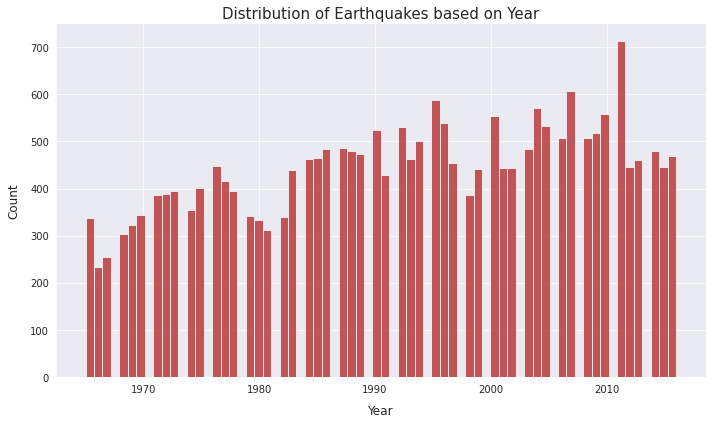

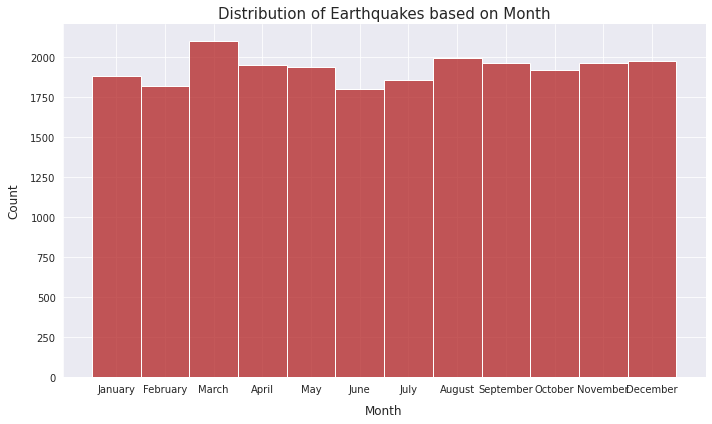

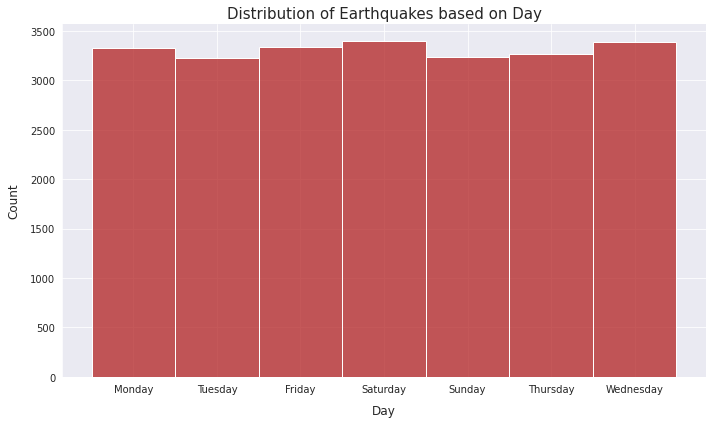

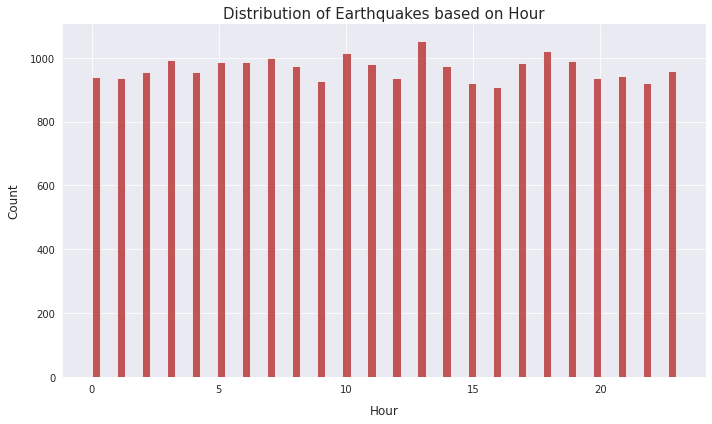

In [31]:
# Create separate plots for each of the 'Year', 'Month', 'Day' and 'Hour' columns

for column in ['Year', 'Month', 'Day', 'Hour']:
    plt.figure(figsize=(10,6))
    sns.histplot(df[column], bins=70, color='firebrick', kde=False)
    plt.xlabel(column, fontsize=12, labelpad=10)
    plt.ylabel('Count', fontsize=12, labelpad=10)
    plt.title(f'Distribution of Earthquakes based on {column}', fontsize=15)
    plt.tight_layout()
    sns.despine()
    plt.show()


Conclusion:
1. 2011 had the highest number of earthquakes recorded : 713, while the least was 1966 with 233 which would be because there were those not recorded in the earlier years. 
2. March had more records with 2104 cases while June had the least number of cases with 1807. 
3. The 11th day of the month is the most likely to experience an earthquake since it has the highest number with 900, followed by the 17 th day with 840 while the 31st is least likely to have an earthquake since it has 345 cases.
4. The 13 hour of the day is most likely to have an earthquake with 1055 cases while the 16 hour is the least likely with 909 cases.

In [32]:
df['Magnitude Type'].value_counts()

MW     7717
MWC    5650
MB     3594
MWB    2457
MWW    1983
MS     1700
ML       56
MWR      26
MH        5
MD        4
Name: Magnitude Type, dtype: int64

In [33]:
# Group categories with frequency less than 1000

other_cutoff = 1000
df['Magnitude Type'] = np.where(df['Magnitude Type'].isin(df['Magnitude Type'].value_counts()[df['Magnitude Type'].value_counts() < other_cutoff].index), 'Other', df['Magnitude Type'])

# Print the reduced categories
print(df['Magnitude Type'].value_counts())


MW       7717
MWC      5650
MB       3594
MWB      2457
MWW      1983
MS       1700
Other      91
Name: Magnitude Type, dtype: int64


In [34]:
df.corr()

,Latitude,Longitude,Depth,Magnitude,Distance,Hour,Year
Latitude,1.000000,0.205608,-0.022254,0.034150,-0.054259,0.000692,-0.068453
Longitude,0.205608,1.000000,0.009001,0.037774,-0.183224,-0.010519,-0.038663
Depth,-0.022254,0.009001,1.000000,0.000508,0.009599,0.004205,-0.149963
Magnitude,0.034150,0.037774,0.000508,1.000000,-0.001090,0.005351,-0.034246
Distance,-0.054259,-0.183224,0.009599,-0.001090,1.000000,0.005758,-0.005211
Hour,0.000692,-0.010519,0.004205,0.005351,0.005758,1.000000,-0.001444
Year,-0.068453,-0.038663,-0.149963,-0.034246,-0.005211,-0.001444,1.000000


In [35]:
# Extract the numerical features you want to check for multicollinearity
num_features = df.select_dtypes(include=['float64', 'int64'])
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Compute the VIF for each feature
vif = pd.DataFrame()
vif["feature"] = num_features.columns
vif["VIF"] = [variance_inflation_factor(num_features.values, i) for i in range(num_features.shape[1])]

# Print the VIF for each feature
print(vif)

     feature         VIF
0   Latitude    1.048668
1  Longitude    1.188210
2      Depth   12.630691
3  Magnitude  647.180771
4   Distance    2.983582
5       Hour    3.780707
6       Year  655.602150


The features have 

In [36]:
# Encode the categorical features

df = pd.get_dummies(df)

In [37]:
gc.collect()

49172

### **Modeling**

In [38]:
# Split into features and target 

X = df.drop('Magnitude', axis=1)
y = df['Magnitude']

# Split the data into train and test 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [39]:
scaler = StandardScaler()

# Remove 'Depth' from X_train and X_test
X_train_scaled = X_train.drop(columns=['Depth'])  # Depth has been log transformed
X_test_scaled = X_test.drop(columns=['Depth'])

# Scale the remaining features

X_train_scaled = scaler.fit_transform(X_train_scaled)
X_test_scaled = scaler.transform(X_test_scaled)

# Combine the scaled features with the scaled 'Depth' column

X_train_scaled = np.hstack((X_train_scaled, X_train['Depth'].values.reshape(-1, 1)))
X_test_scaled = np.hstack((X_test_scaled, X_test['Depth'].values.reshape(-1, 1)))

In [40]:
# create new dataframes with the scaled data and original column names
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [41]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16234, 32), (16234, 1), (6958, 32), (6958, 1))

**Random Forest Regressor**

In [42]:
# Create and train the model
model1 = RandomForestRegressor(n_estimators=200, random_state=42)
model1.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model1.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean squared error: {:.6f}".format(mse))
print("Root Mean Squared Error :{:.6f}".format(rmse))

Mean squared error: 0.004102
Root Mean Squared Error :0.064045


In [43]:
# Extract the feature importances as a dictionary

importances = model1.feature_importances_
importances_dict = dict(zip(X_train.columns, importances))

print("Random Forest feature importances:")
for feature, importance in sorted(importances_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Random Forest feature importances:
Longitude: 0.1422
Latitude: 0.1369
Depth: 0.1368
Month_September: 0.1271
Hour: 0.1132
Distance: 0.0888
Year: 0.0459
Magnitude Type_Other: 0.0115
Day_Friday: 0.0113
Day_Tuesday: 0.0108
Day_Saturday: 0.0107
Day_Monday: 0.0106
Day_Sunday: 0.0103
Month_November: 0.0101
Day_Thursday: 0.0100
Month_May: 0.0096
Day_Wednesday: 0.0095
Month_June: 0.0095
Month_March: 0.0093
Month_July: 0.0091
Month_April: 0.0090
Month_August: 0.0089
Month_February: 0.0086
Month_January: 0.0083
Month_October: 0.0083
Magnitude Type_MWC: 0.0082
Month_December: 0.0076
Magnitude Type_MW: 0.0058
Magnitude Type_MS: 0.0057
Magnitude Type_MWB: 0.0031
Magnitude Type_MB: 0.0027
Magnitude Type_MWW: 0.0005


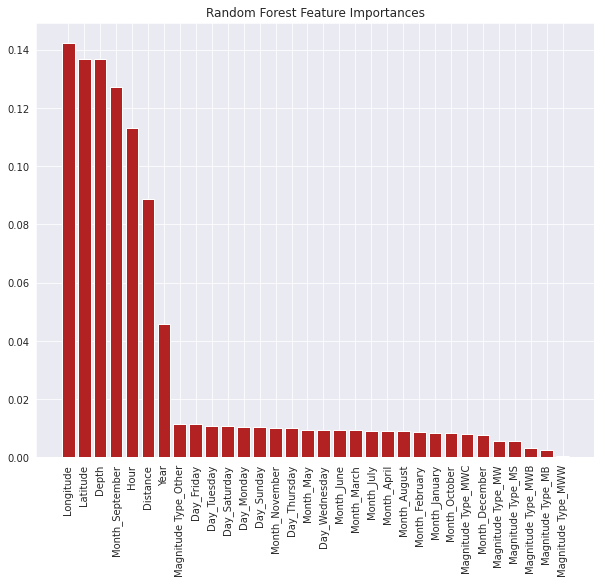

In [44]:
# Plot feature importances

importances_sorted = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*importances_sorted)

plt.figure(figsize=(10,8))
plt.bar(features, importances, color='firebrick')
plt.xticks(rotation=90)
plt.title("Random Forest Feature Importances")
plt.show()

In [45]:
# Select k features based on feature importances

importances = model1.feature_importances_

k = 29
top_k = importances.argsort()[::-1][:k]

X_train_top_k = X_train.iloc[:, top_k]
X_test_top_k = X_test.iloc[:, top_k]

# Train model on selected features
model1.fit(X_train_top_k, y_train)

# Predictions
y_pred_top_k = model1.predict(X_test_top_k)

#Evaluate model 
mse= mean_squared_error(y_test, y_pred_top_k)
rmse = np.sqrt(mse)

print("Mean squared error: {:.6f}".format(mse))
print("Root Mean Squared Error :{:.6f}".format(rmse))

Mean squared error: 0.004096
Root Mean Squared Error :0.063998


**Decision Tree Regressor**

In [46]:
# Create and train the model

model2 =DecisionTreeRegressor(random_state=42)
model2.fit(X_train, y_train)

# Make predictions on the testing set
y_pred = model2.predict(X_test)

# Evaluate the model performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print("Mean squared error: {:.4f}".format(mse))
print("Root Mean Squared Error :{:.4f}".format(rmse))

Mean squared error: 0.0079
Root Mean Squared Error :0.0888


In [47]:
# Extract the feature importances as a dictionary

importances = model2.feature_importances_
importances_dict = dict(zip(X_train.columns, importances))

print("Decion Tree feature importances:")
for feature, importance in sorted(importances_dict.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {importance:.4f}")

Decion Tree feature importances:
Longitude: 0.1473
Latitude: 0.1422
Depth: 0.1319
Month_September: 0.1165
Hour: 0.1151
Distance: 0.0885
Year: 0.0457
Day_Tuesday: 0.0134
Month_June: 0.0126
Day_Saturday: 0.0124
Month_November: 0.0113
Day_Sunday: 0.0109
Magnitude Type_Other: 0.0108
Month_May: 0.0103
Month_August: 0.0102
Day_Thursday: 0.0102
Day_Friday: 0.0099
Day_Wednesday: 0.0099
Month_October: 0.0096
Day_Monday: 0.0094
Month_February: 0.0093
Month_March: 0.0088
Month_July: 0.0086
Month_January: 0.0084
Month_December: 0.0079
Magnitude Type_MWC: 0.0079
Month_April: 0.0067
Magnitude Type_MS: 0.0067
Magnitude Type_MW: 0.0042
Magnitude Type_MWB: 0.0016
Magnitude Type_MB: 0.0013
Magnitude Type_MWW: 0.0005


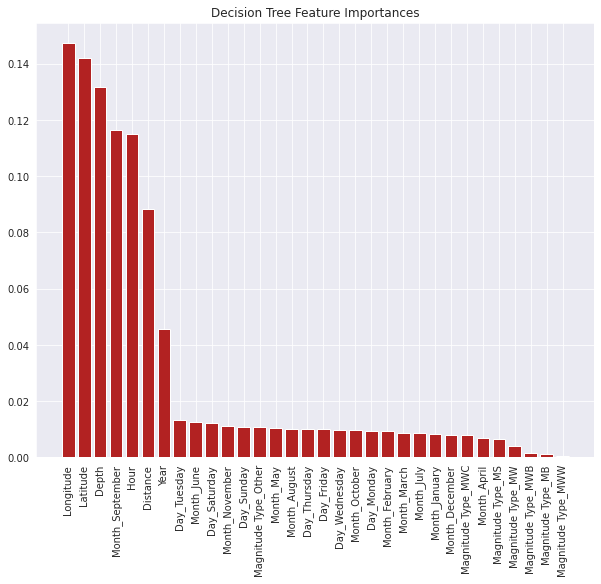

In [48]:
# Plot feature importances

importances_sorted = sorted(importances_dict.items(), key=lambda x: x[1], reverse=True)
features, importances = zip(*importances_sorted)

plt.figure(figsize=(10,8))
plt.bar(features, importances, color='firebrick')
plt.xticks(rotation=90)
plt.title("Decision Tree Feature Importances")
plt.show()

In [49]:
# Select k features based on feature importances

importances = model2.feature_importances_

k = 33
top_k = importances.argsort()[::-1][:k]

X_train_top_k = X_train.iloc[:, top_k]
X_test_top_k = X_test.iloc[:, top_k]

# Train model on selected features
model2.fit(X_train_top_k, y_train)

# Predictions
y_pred_top_k = model2.predict(X_test_top_k)

#Evaluate model 
mse= mean_squared_error(y_test, y_pred_top_k)
rmse = np.sqrt(mse)

print("Mean squared error: {:.6f}".format(mse))
print("Root Mean Squared Error :{:.6f}".format(rmse))

Mean squared error: 0.008018
Root Mean Squared Error :0.089541
